In [1]:
import torch
import pickle
from matplotlib import colors
import matplotlib.pyplot as plt
from joblib import load
from pathlib import Path
import os
import numpy as np
import sys
from config import ROOT_DIR
import pandas as pd
from libpysal.weights import Queen, Rook, DistanceBand, lat2W, WSP
from pysal.model import spreg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import block_diag, csr_matrix
import pysal.lib as lib



sys.path.append("/Users/kevindesilva/ESC403_Project")
print(sys.path)

['/Users/kevindesilva/ESC403_Project/Notebooks', '/Users/kevindesilva/ESC403_Project', '/Users/kevindesilva/anaconda3/lib/python311.zip', '/Users/kevindesilva/anaconda3/lib/python3.11', '/Users/kevindesilva/anaconda3/lib/python3.11/lib-dynload', '', '/Users/kevindesilva/anaconda3/lib/python3.11/site-packages', '/Users/kevindesilva/anaconda3/lib/python3.11/site-packages/aeosa', '/opt/gurobi201/linux32/lib/python2.5', '/Users/kevindesilva/ESC403_Project']


In [2]:
testing = True
read_path = r"Data/trial/" if testing else r"Data/feature_engineered/"

X = load(ROOT_DIR / Path(read_path, "X_fe.pkl"))
y = load(ROOT_DIR / Path(read_path, "y_fe.pkl"))

In [3]:
print(type(X), X.shape)
print(type(y), y.shape)

<class 'torch.Tensor'> torch.Size([100, 64, 64, 15])
<class 'torch.Tensor'> torch.Size([100, 64, 64, 1])


#1: Elevation
#2: Wind direction
#3: Wind velocity
#4: Min temp
#5: Max temp
#6: Humidity
#7: Precip
#8: Drought
#9: Vegetation
#10: Population density
#11: Energy release component
#12: Previous fire mask
#13: Distance to Fire
#14: Flow Accumulation
#15: Fire Direction


#Y 1: Next Day Fire Mask


In [4]:

X_np = X.numpy()
y_np = y.numpy()


In [5]:
# Train-Test split

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42)


X_train = torch.tensor(X_train_np)
X_test = torch.tensor(X_test_np)
y_train = torch.tensor(y_train_np)
y_test = torch.tensor(y_test_np)

print("Trainingsdaten Formen:", X_train.shape, y_train.shape)
print("Testdaten Formen:", X_test.shape, y_test.shape)

Trainingsdaten Formen: torch.Size([80, 64, 64, 15]) torch.Size([80, 64, 64, 1])
Testdaten Formen: torch.Size([20, 64, 64, 15]) torch.Size([20, 64, 64, 1])


In [6]:
print(type(X_train_np), X_train_np.shape)
print(type(y_train_np), y_train_np.shape)

<class 'numpy.ndarray'> (80, 64, 64, 15)
<class 'numpy.ndarray'> (80, 64, 64, 1)


In [7]:
# Um das SAR Modell anzuwenden müssen die Daten 2D sein

# Um SAR-Modelle anzuwenden, reshapen wir die Daten so, dass das Raster (64x64) beibehalten wird
n_samples, height, width, n_features = X_train_np.shape

# Reshape der Eingabedaten (X) und der Zielvariablen (y)
X_train_reshaped = X_train_np.reshape(n_samples * height * width, n_features)
y_train_reshaped = y_train_np.reshape(n_samples * height * width, 1)


# Erzeuge die Gewichtsmatrix für das gesamte Dataset
# Da wir hier mit 80 64x64-Rastern arbeiten, müssen wir eine Gewichtsmatrix für das gesamte Dataset erstellen
# Das bedeutet, dass wir eine blockdiagonale Matrix erstellen müssen, die 80-mal die 64x64-Matrix enthält


# Erzeuge eine Gewichtsmatrix für ein einzelnes 64x64-Raster
w_single = lib.weights.lat2W(height, width)

w_blocks = block_diag([w_single.sparse for _ in range(n_samples)], format='csr')

# Konvertiere die blockdiagonale Matrix in ein PySAL W-Objekt
# Wir müssen die Matrix manuell in das richtige Format konvertieren
neighbors = {}
weights = {}
for i in range(n_samples):
    for key, vals in w_single.neighbors.items():
        new_key = key + i * height * width
        new_vals = [val + i * height * width for val in vals]
        neighbors[new_key] = new_vals
        weights[new_key] = w_single.weights[key]

w = lib.weights.W(neighbors, weights)

w.transform = 'r'

/var/folders/t7/b1d1yp6d79z33w_6jvk6wcr80000gn/T/ipykernel_84759/1079147782.py:32: UserWarning: The weights matrix is not fully connected: 
 There are 80 disconnected components.
  w = lib.weights.W(neighbors, weights)


In [8]:
sar_model = spreg.GM_Error(y_train_reshaped, X_train_reshaped, w=w, name_y='y', name_x=['X' + str(i) for i in range(n_features)])

# Modell-Details anzeigen

print(sar_model.summary)

In [17]:

print(sar_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           y                Number of Observations:      327680
Mean dependent var  :     -0.0928                Number of Variables   :          16
S.D. dependent var  :      0.3078                Degrees of Freedom    :      327664
Pseudo R-squared    :      0.2173

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.08299         0.03102        -2.67561         0.00746
                  X0         0.00001         0.00000         6.68452         0.00000
                  X1         0.00010         0.00002         5.77211

In [20]:

print(type(X_train_np), X_train_np.shape)
print(type(y_train_np), y_train_np.shape)

# Reshape 
n_samples_train, height, width, n_features = X_train_np.shape
n_samples_test = X_test_np.shape[0]
n_samples_total = n_samples_train + n_samples_test

# Reshape 
X_train_reshaped = X_train_np.reshape(n_samples_train * height * width, n_features)
y_train_reshaped = y_train_np.reshape(n_samples_train * height * width, 1)


w_single = lib.weights.lat2W(height, width)


w_blocks_train = block_diag([w_single.sparse for _ in range(n_samples_train)], format='csr')


neighbors_train = {}
weights_train = {}
for i in range(n_samples_train):
    for key, vals in w_single.neighbors.items():
        new_key = key + i * height * width
        new_vals = [val + i * height * width for val in vals]
        neighbors_train[new_key] = new_vals
        weights_train[new_key] = w_single.weights[key]

w_train = lib.weights.W(neighbors_train, weights_train)
w_train.transform = 'r'


X_full_np = np.vstack((X_train_np, X_test_np)).reshape(n_samples_total * height * width, n_features)


w_blocks_full = block_diag([w_single.sparse for _ in range(n_samples_total)], format='csr')


neighbors_full = {}
weights_full = {}
for i in range(n_samples_total):
    for key, vals in w_single.neighbors.items():
        new_key = key + i * height * width
        new_vals = [val + i * height * width for val in vals]
        neighbors_full[new_key] = new_vals
        weights_full[new_key] = w_single.weights[key]

w_full = lib.weights.W(neighbors_full, weights_full)
w_full.transform = 'r'

slx_model = spreg.OLS(y_train_reshaped, X_train_reshaped, w=w_train, name_y='y', name_x=['X' + str(i) for i in range(n_features)], slx_lags=1)


WX_full = w_full.sparse @ X_full_np


WX_new = WX_full[n_samples_train * height * width:]


X_test_reshaped = X_test_np.reshape(n_samples_test * height * width, n_features)
X_new_with_WX = np.column_stack((X_test_reshaped, WX_new))

# Add an intercept 
intercept = np.ones((X_new_with_WX.shape[0], 1))
X_new_with_WX_intercept = np.column_stack((intercept, X_new_with_WX))

# Ensure dimensions match 
print(f"X_new_with_WX_intercept shape: {X_new_with_WX_intercept.shape}")
print(f"slx_model.betas shape: {slx_model.betas.shape}")

# Predict out of sample
y_pred = X_new_with_WX_intercept @ slx_model.betas

# Reshape the predictions back to the original shape
y_pred_reshaped = y_pred.reshape(n_samples_test, height, width, 1)

print(y_pred_reshaped)


<class 'numpy.ndarray'> (80, 64, 64, 15)
<class 'numpy.ndarray'> (80, 64, 64, 1)


/var/folders/t7/b1d1yp6d79z33w_6jvk6wcr80000gn/T/ipykernel_84759/1403394221.py:32: UserWarning: The weights matrix is not fully connected: 
 There are 80 disconnected components.
  w_train = lib.weights.W(neighbors_train, weights_train)
/var/folders/t7/b1d1yp6d79z33w_6jvk6wcr80000gn/T/ipykernel_84759/1403394221.py:51: UserWarning: The weights matrix is not fully connected: 
 There are 100 disconnected components.
  w_full = lib.weights.W(neighbors_full, weights_full)


X_new_with_WX_intercept shape: (81920, 31)
slx_model.betas shape: (31, 1)
[[[[ 8.10251710e-02]
   [ 9.79271143e-02]
   [ 9.67247888e-02]
   ...
   [ 1.03800060e-01]
   [ 1.04272991e-01]
   [ 1.69838827e-01]]

  [[ 6.72439057e-02]
   [ 8.06186030e-02]
   [ 8.09790475e-02]
   ...
   [ 7.09903500e-02]
   [ 6.98468978e-02]
   [ 1.19618537e-01]]

  [[ 7.35380551e-02]
   [ 8.92352638e-02]
   [ 7.98178884e-02]
   ...
   [ 5.57147040e-02]
   [ 5.44843649e-02]
   [ 8.89827241e-02]]

  ...

  [[-2.99310349e-01]
   [-5.02732586e-01]
   [-4.92167440e-01]
   ...
   [ 4.84915378e-02]
   [ 2.80145894e-02]
   [ 8.11719596e-02]]

  [[-3.41427963e-01]
   [-4.92644709e-01]
   [-4.96073338e-01]
   ...
   [ 3.55727928e-02]
   [ 3.33349109e-02]
   [ 8.78358956e-02]]

  [[-4.13485818e-01]
   [-3.12291732e-01]
   [-4.67011366e-01]
   ...
   [ 6.38330393e-02]
   [ 5.90853324e-02]
   [ 1.29951778e-01]]]


 [[[-2.11221781e-01]
   [-2.07688877e-01]
   [-2.08825742e-01]
   ...
   [-1.57079196e-01]
   [-1.77692415e

In [30]:
print(y_pred_reshaped.shape)

(20, 64, 64, 1)


In [28]:
def summary_stats(array):
    stats = {
        'Min': np.min(array),
        '1st Quartile': np.percentile(array, 25),
        'Median': np.median(array),
        'Mean': np.mean(array),
        '3rd Quartile': np.percentile(array, 75),
        'Max': np.max(array)
    }
    return stats

In [29]:
summary_stats(y_pred_reshaped)

{'Min': -2.704129685362109,
 '1st Quartile': -0.10092813638890887,
 'Median': -0.04219619765270346,
 'Mean': -0.042561976784406444,
 '3rd Quartile': 0.016959504489690018,
 'Max': 4.531157519999125}

y_pred_reshaped shape: (20, 64, 64, 1)


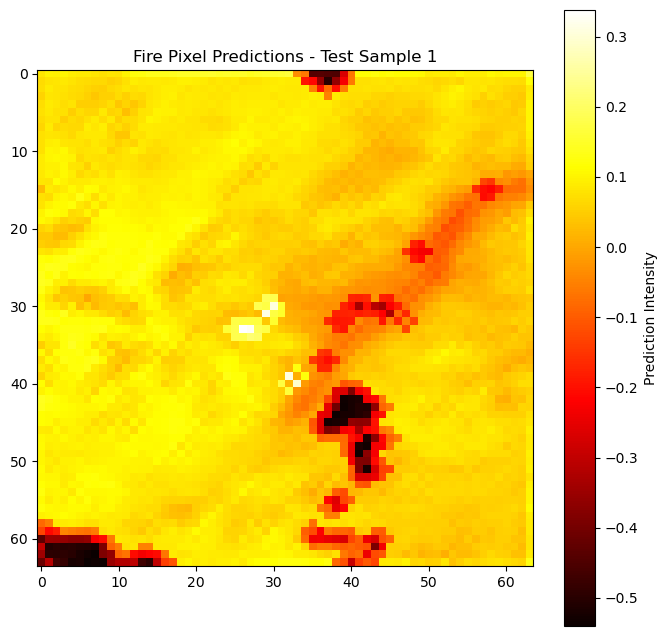

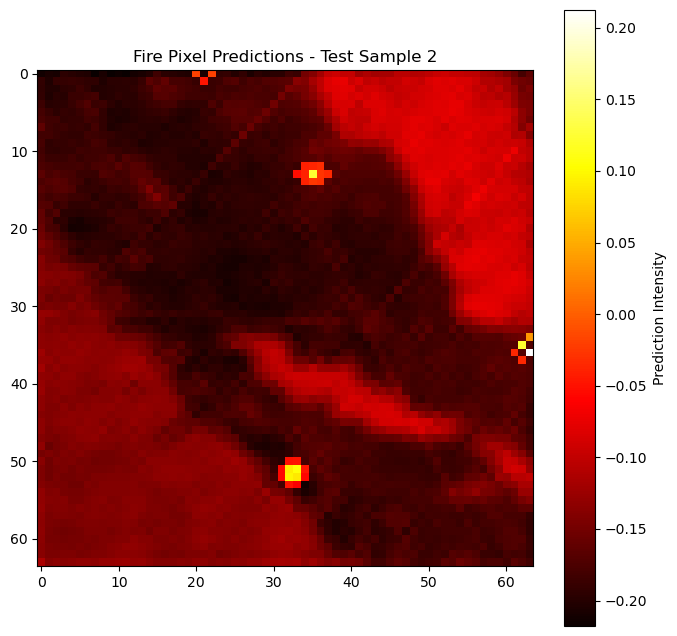

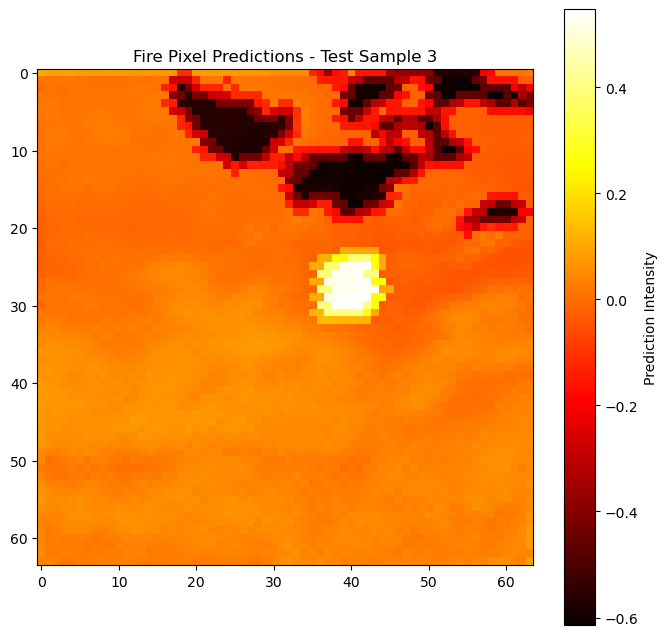

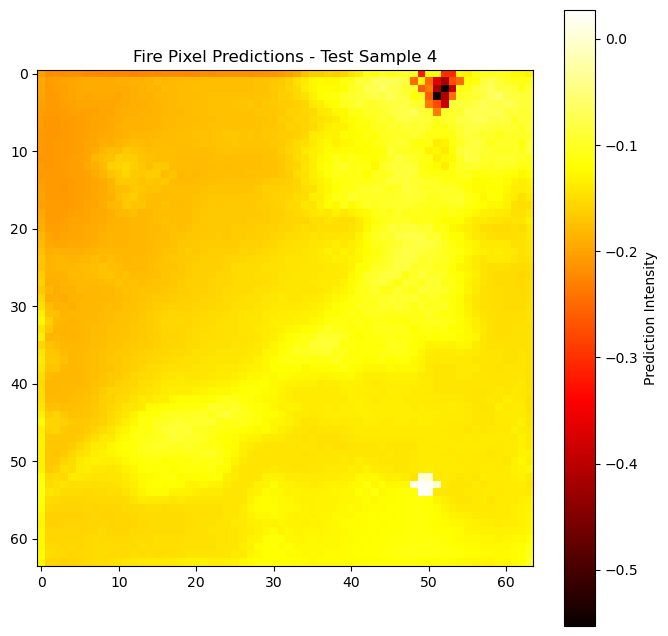

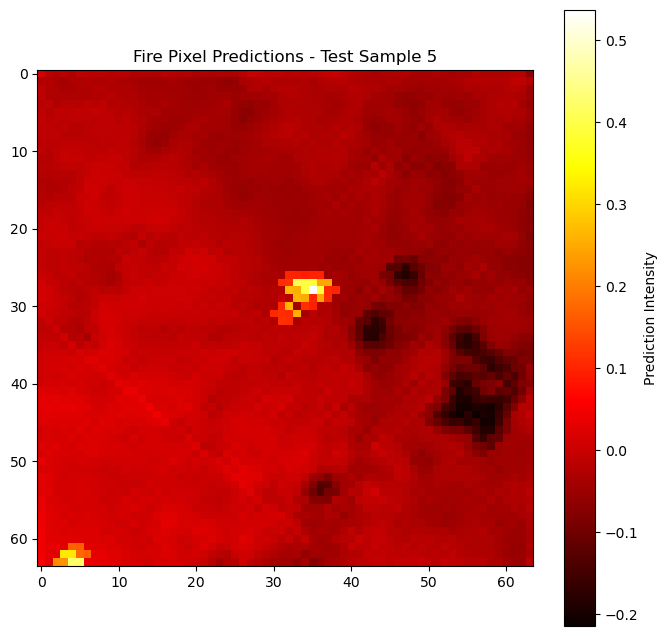

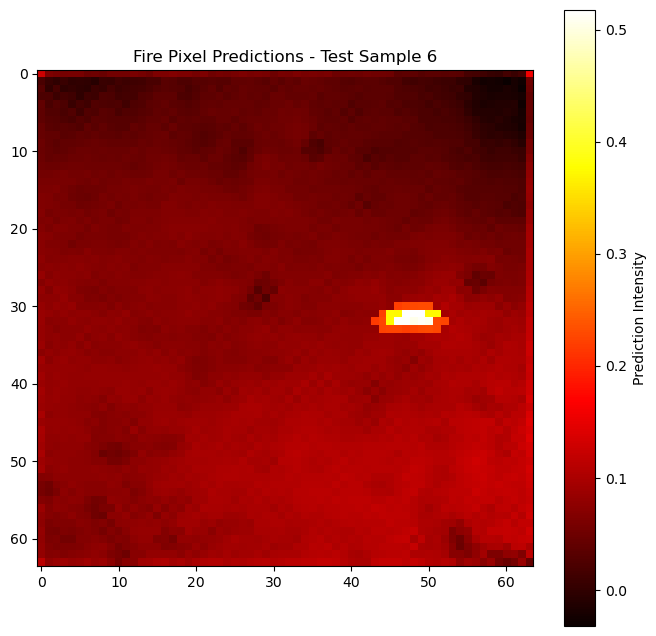

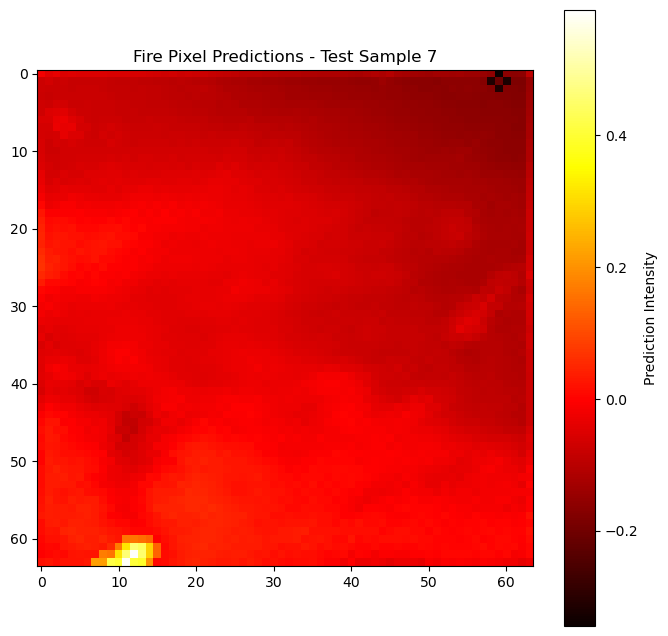

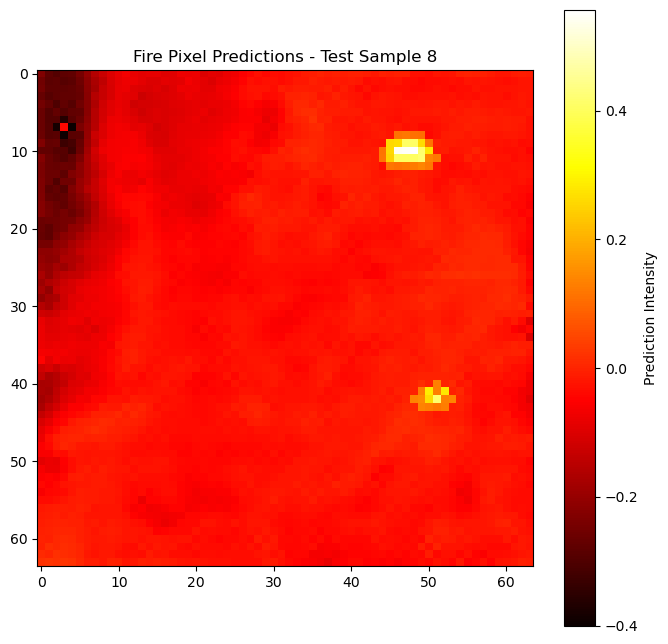

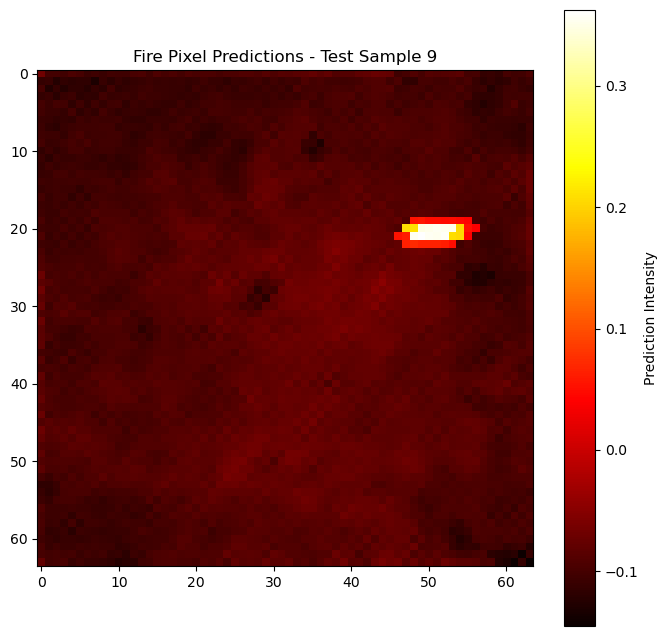

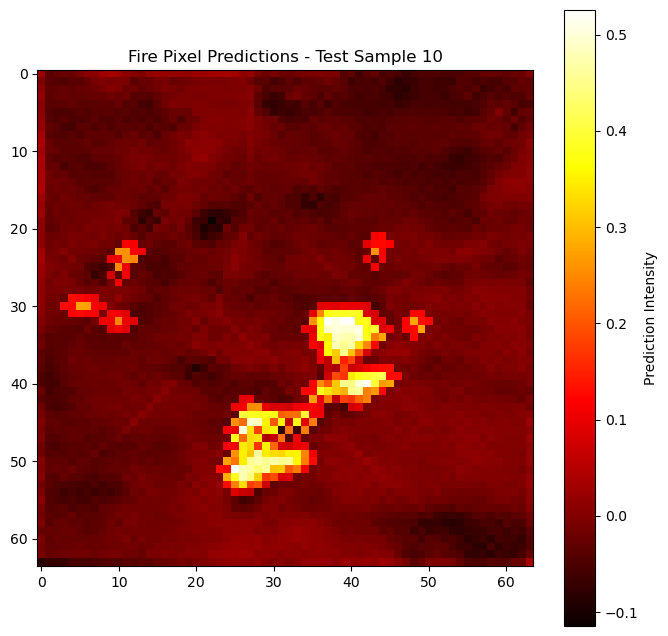

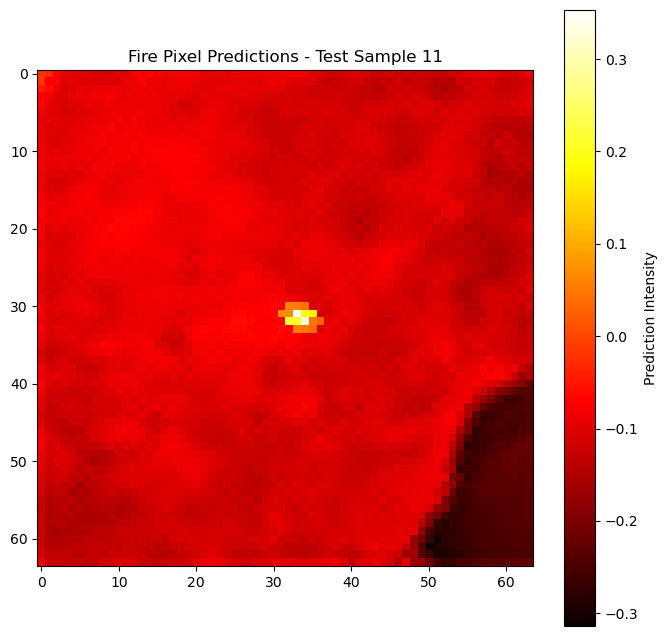

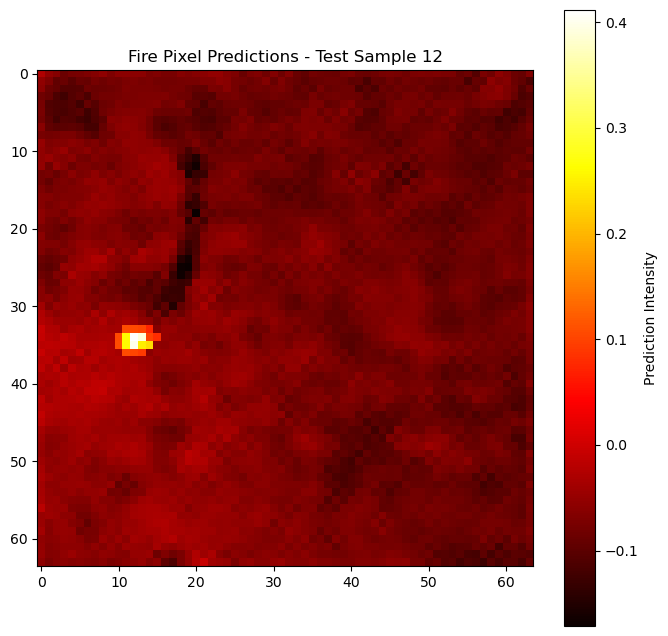

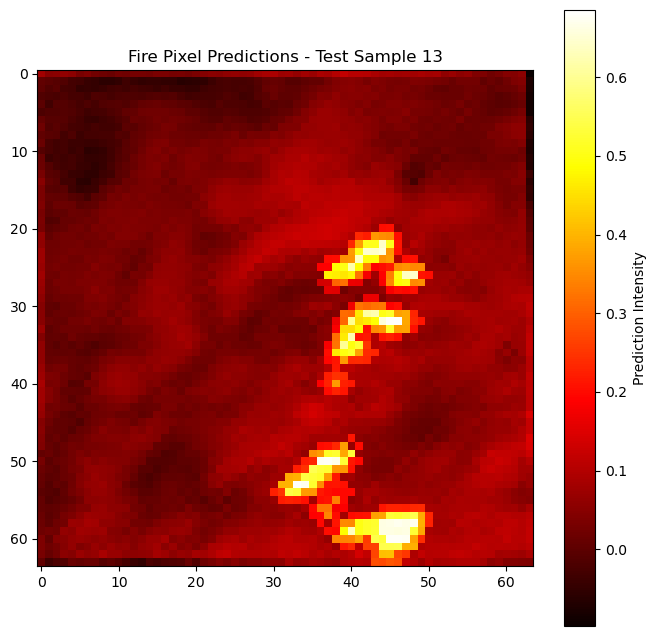

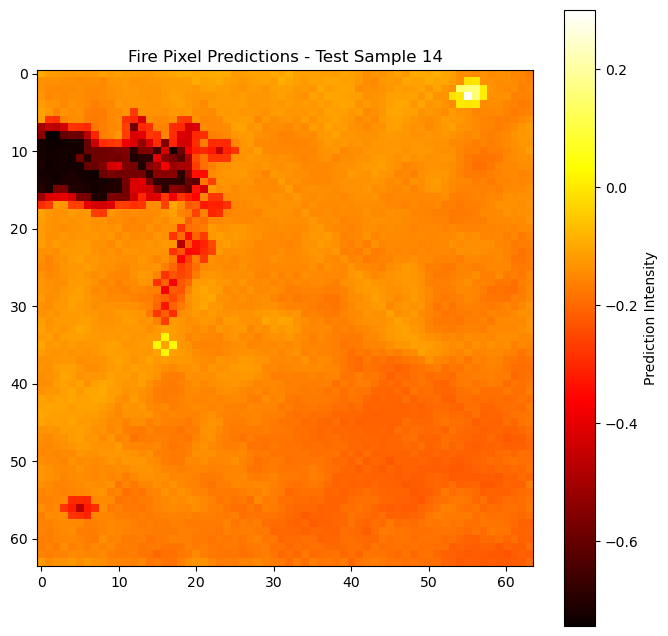

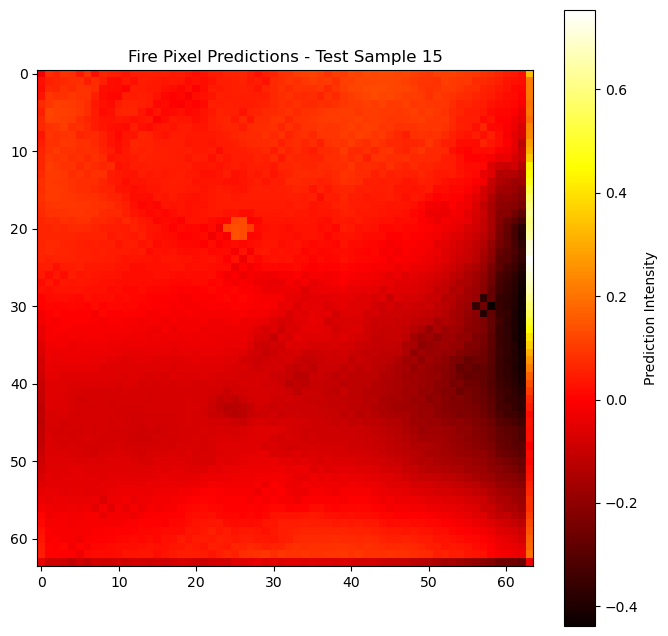

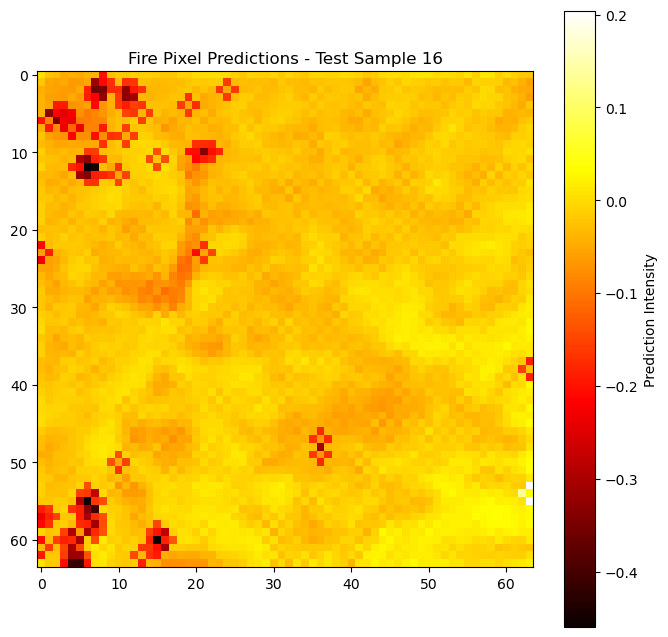

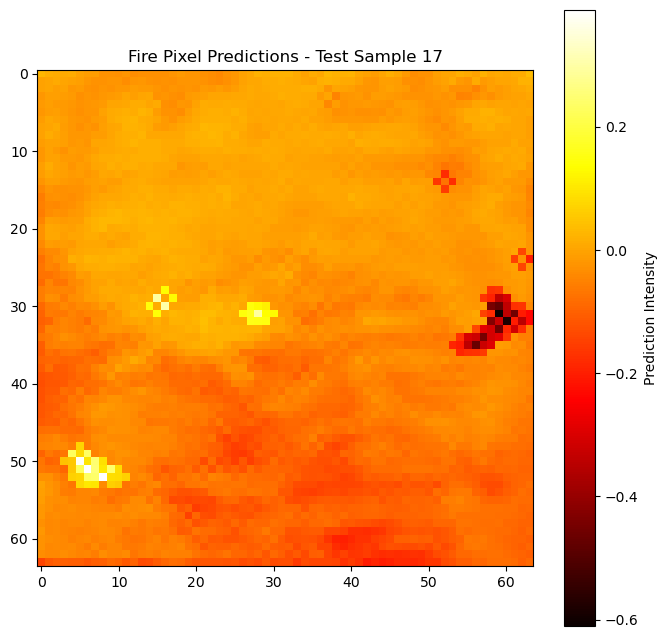

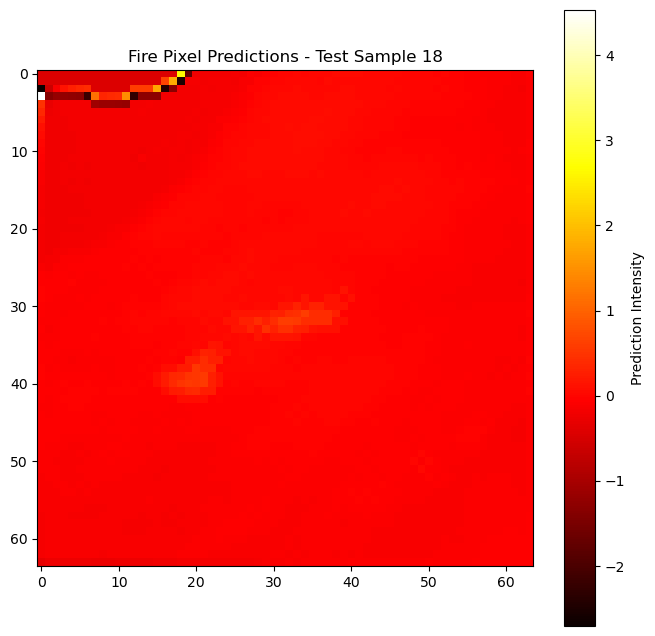

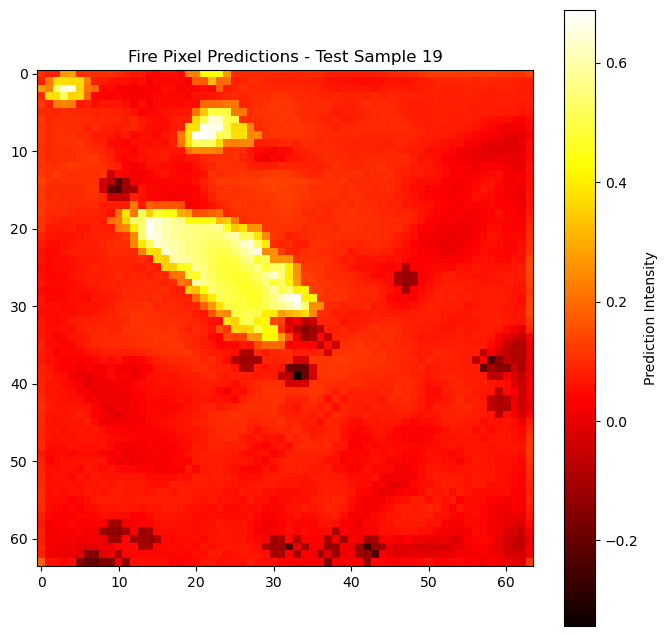

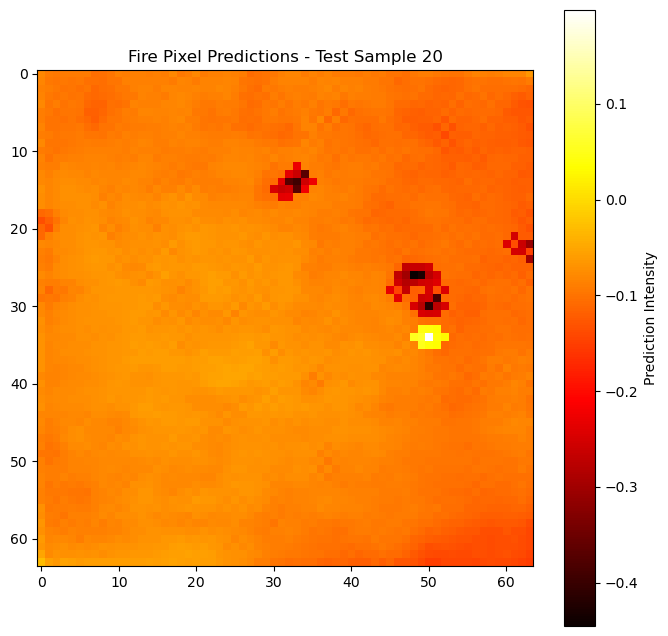

In [32]:
import matplotlib.pyplot as plt

# Ensure predictions are in the correct shape
print(f"y_pred_reshaped shape: {y_pred_reshaped.shape}")

# Plot the predictions for the first test sample

for i in range(n_samples_test):
    plt.figure(figsize=(8, 8))
    plt.title(f'Fire Pixel Predictions - Test Sample {i+1}')
    plt.imshow(y_pred_reshaped[i, :, :, 0], cmap='hot', interpolation='nearest')
    plt.colorbar(label='Prediction Intensity')
    plt.show()


In [40]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

binarized_array = (y_pred_reshaped > 0.5).astype(int)




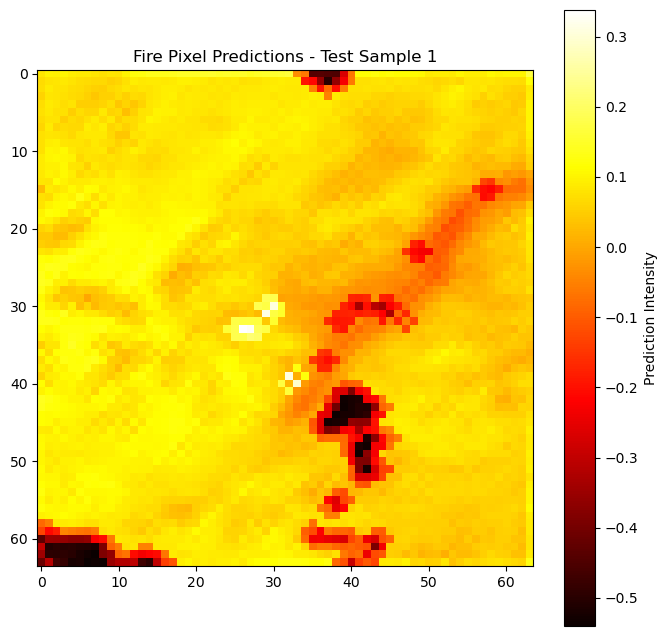

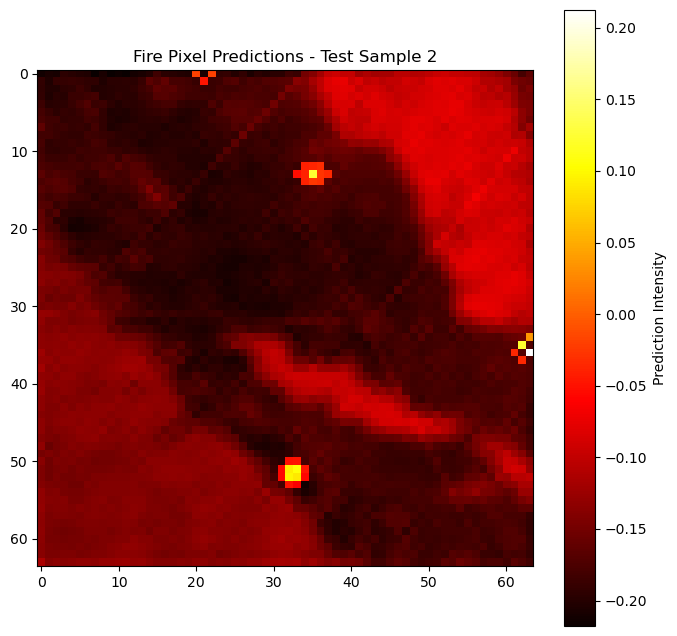

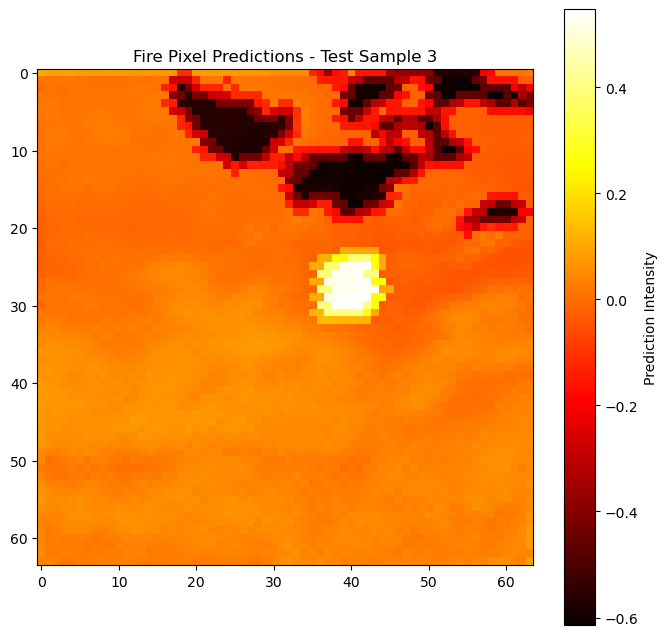

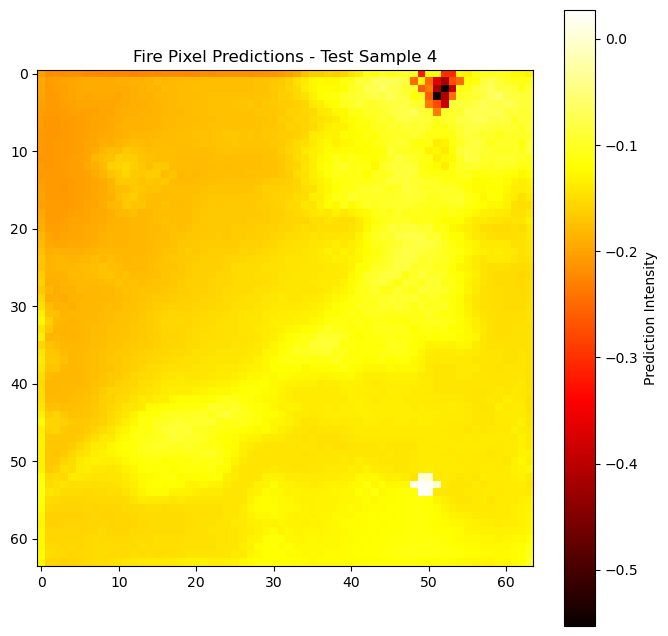

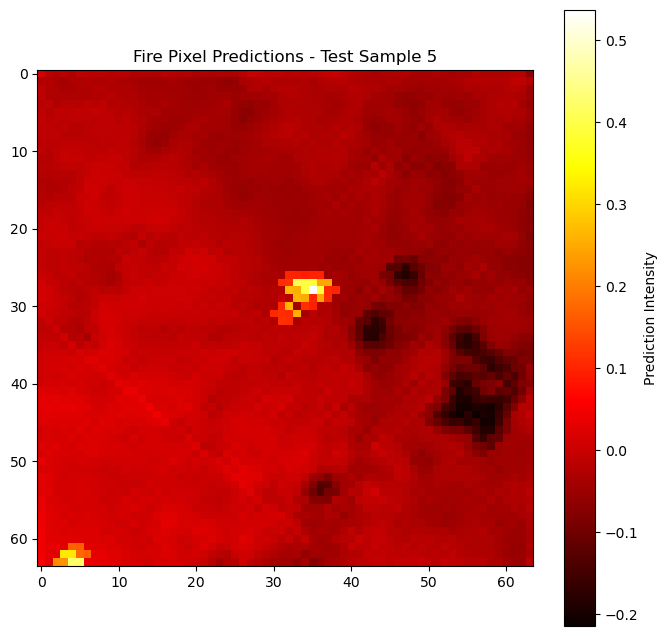

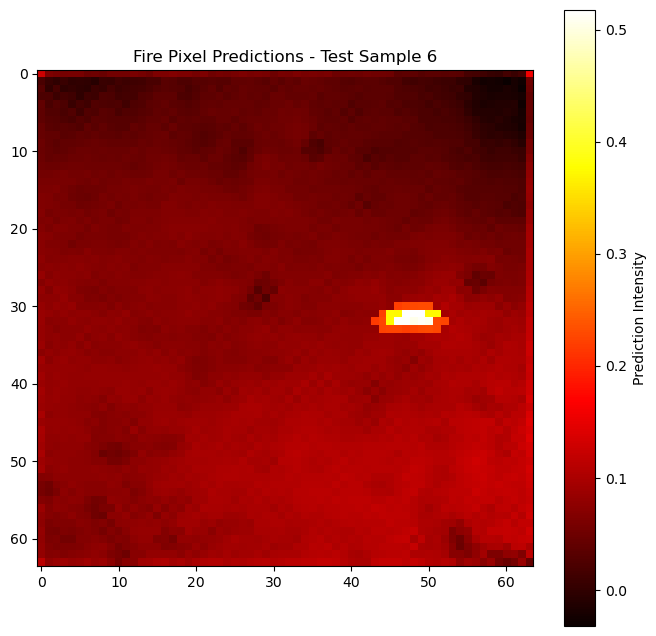

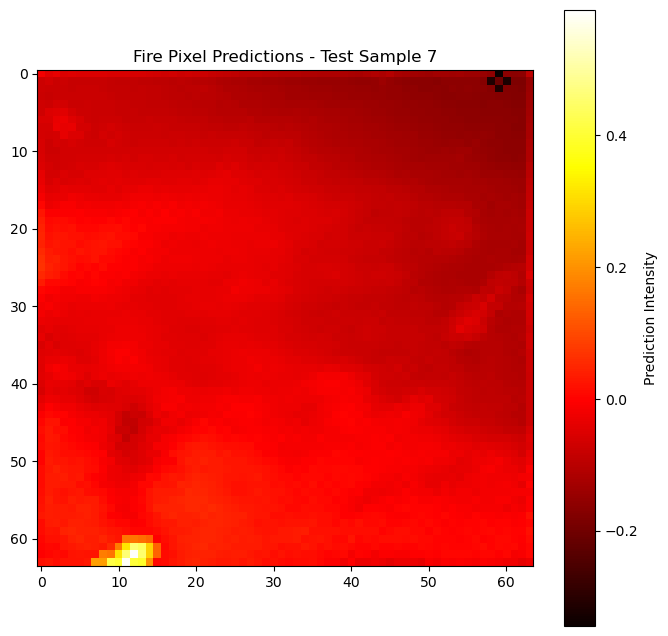

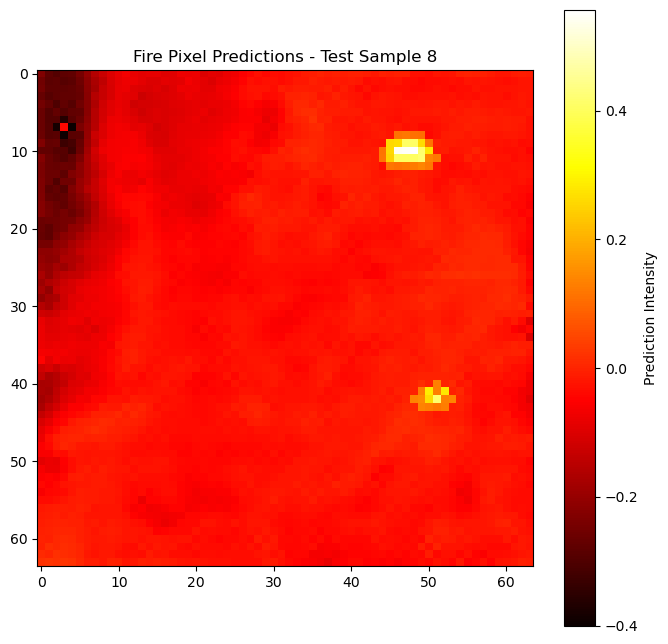

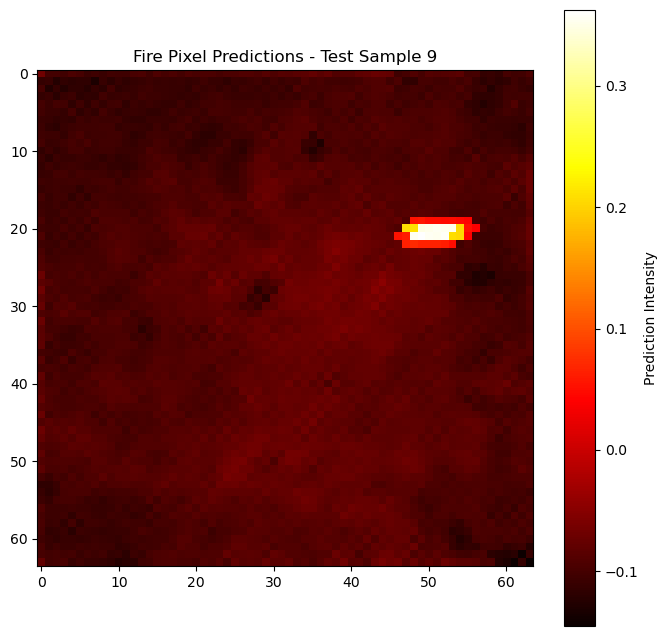

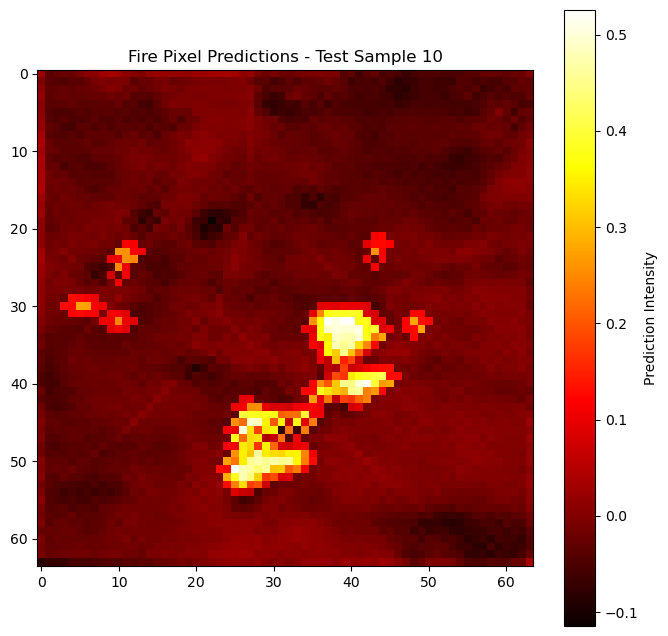

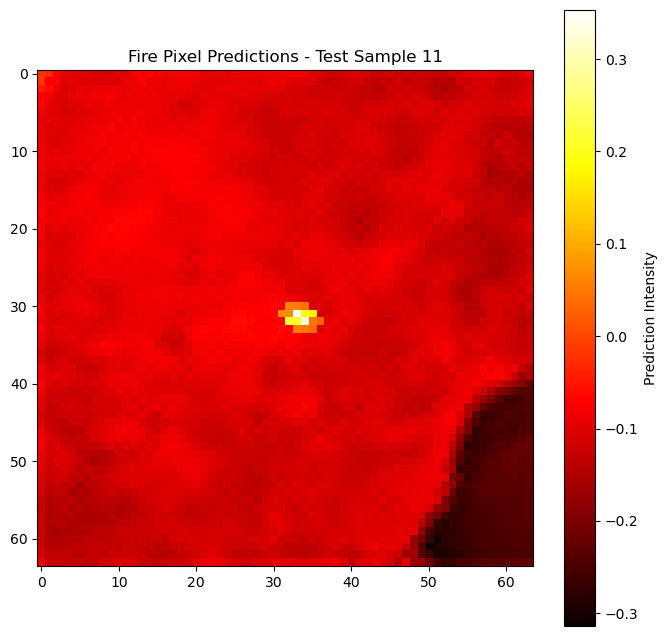

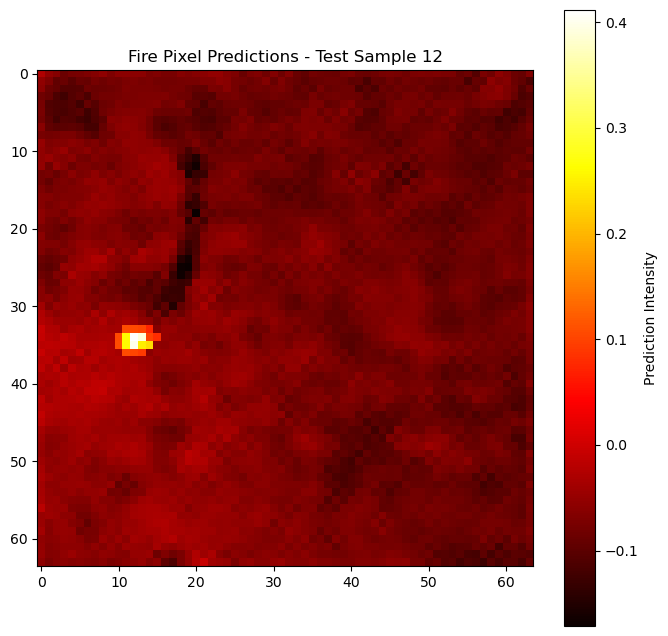

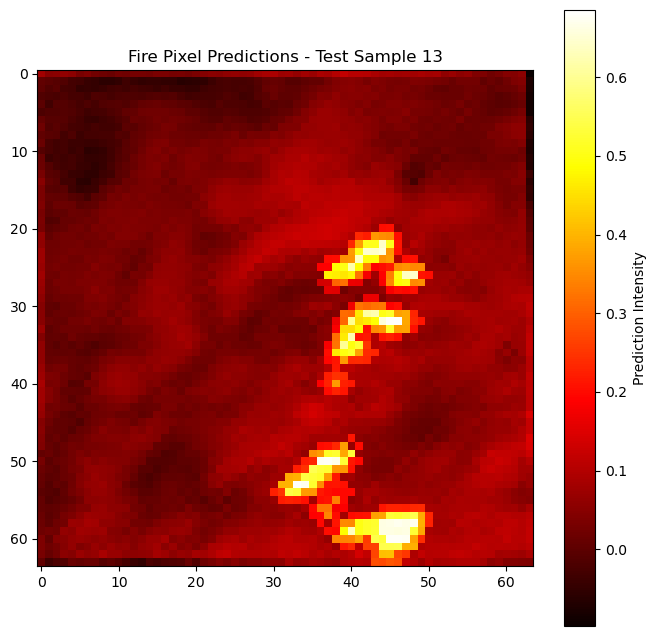

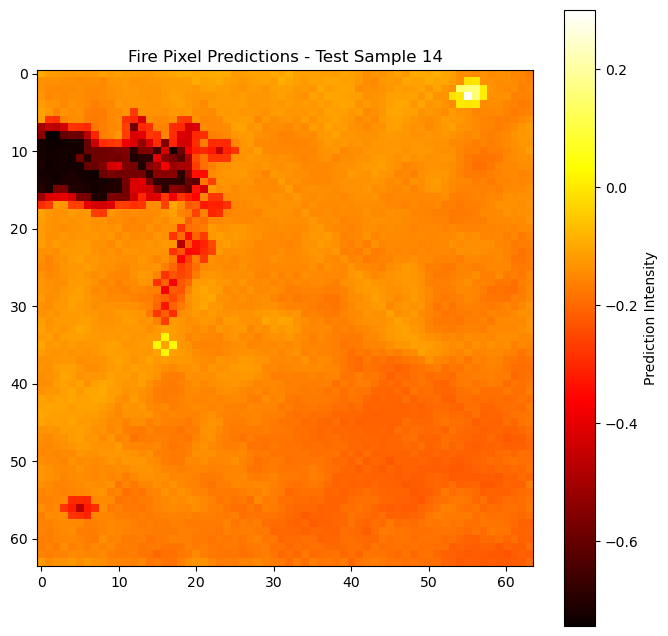

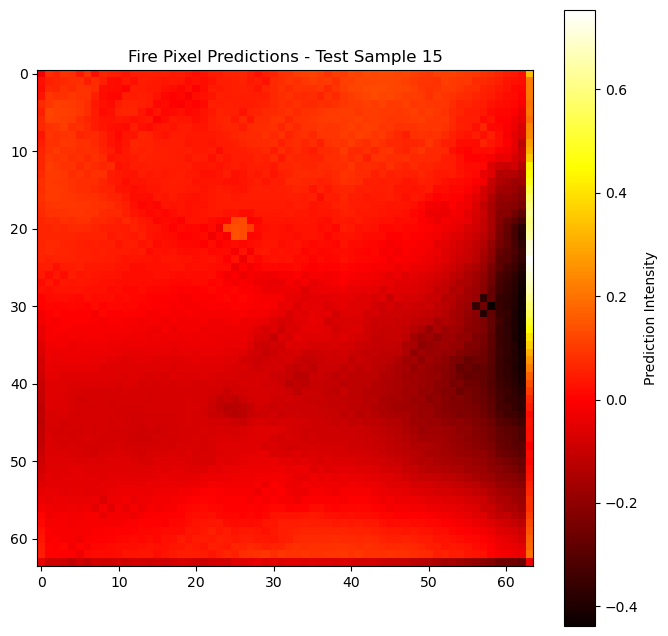

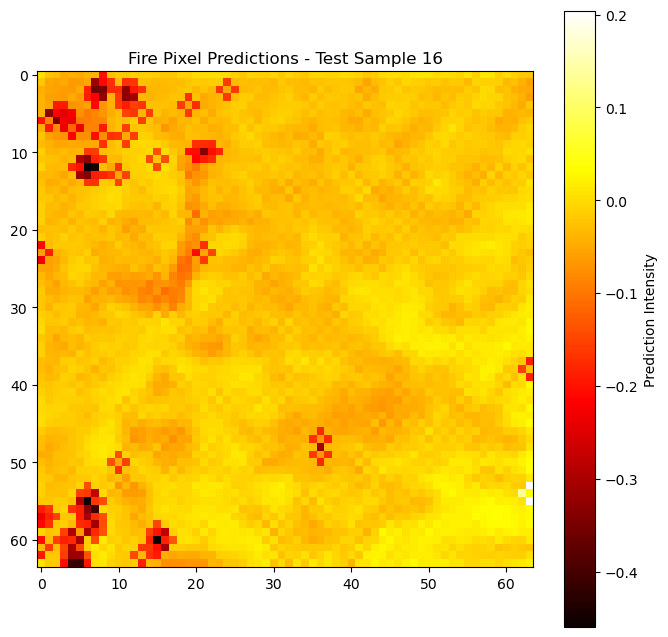

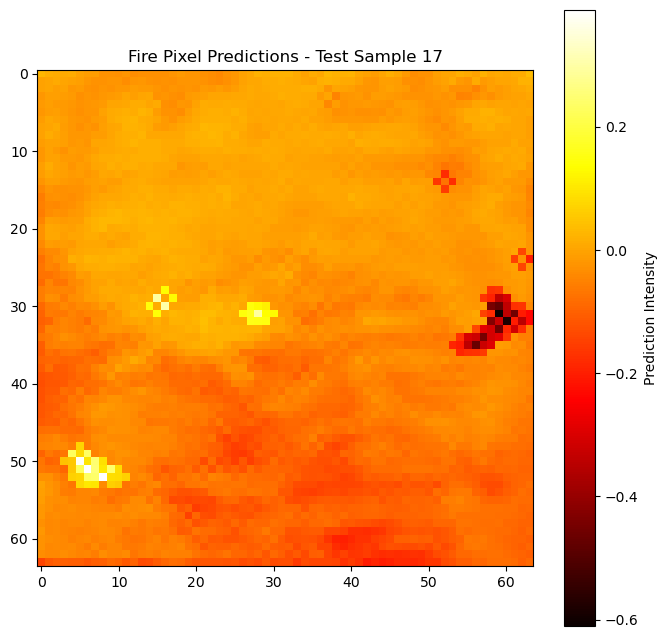

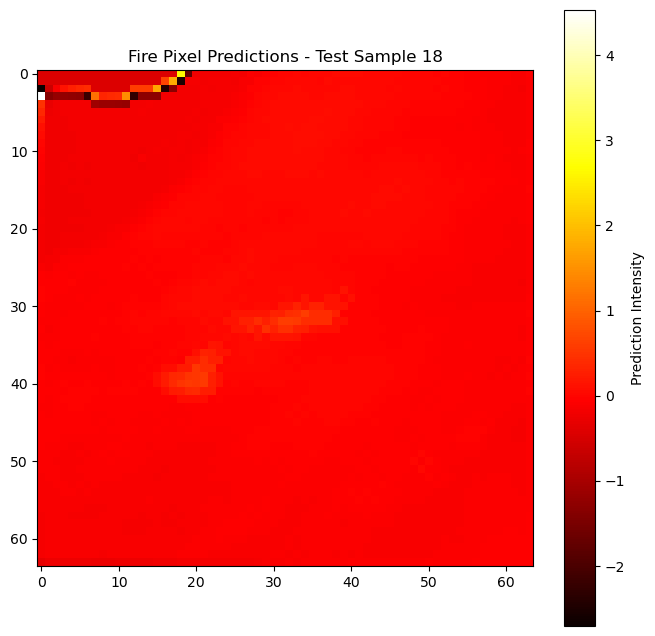

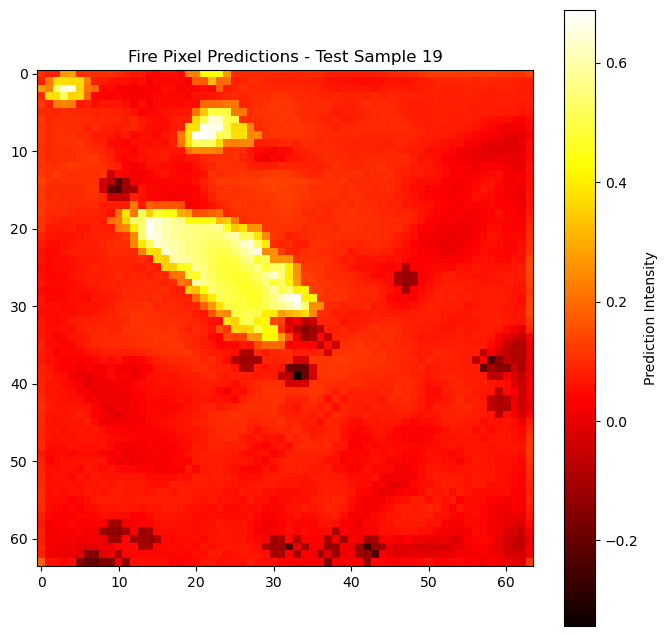

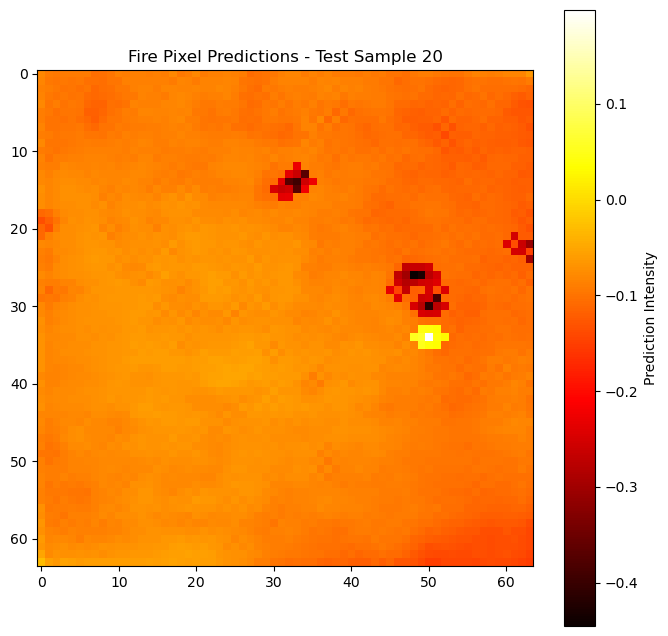

In [42]:
binarized_array = (y_pred_reshaped > 0.5).astype(int)

for i in range(binarized_array.shape[0]):
    plt.figure(figsize=(8, 8))
    plt.title(f'Fire Pixel Predictions - Test Sample {i+1}')
    plt.imshow(y_pred_reshaped[i, :, :, 0], cmap='hot', interpolation='nearest')
    plt.colorbar(label='Prediction Intensity')
    plt.show()

